# Lab Three: Clustering, Association Rules, or Recommenders

In the ﬁnal assignment for this course, we will be using the following analysis method: 

• Option B: Use clustering on an unlabeled dataset to provide insight or features 

By Martin Garcia, Joanna Duran, Daniel Byrne

### Required Packages and preparation for CIFAR-10

In [58]:
#load packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import random
from scipy import ndimage
from sklearn import cluster
from sklearn.preprocessing import StandardScaler  
from sklearn.cluster import KMeans
import pylab as pyl
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
from sklearn import manifold, datasets
from time import time
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

<font color='red'> The functions below help us extract the data split into different batches, and reshaped for our benefit.<font>

In [13]:
#load the data, reshape to 32x32 matrix per color, transpose matrices
def load_cfar10_batch(path, batch_id = 1, reshape = True):
    """
    Argument:
    path -- path the datasets
    batch_id -- id of the batch (1 to 5) to load
    
    Returns:
    parameters -- python dictionary containing:
                    X -- features
                    Y -- labels
    """
    if batch_id is not None:
        filepath = path + 'data_batch_' + str(batch_id)
    else:
        filepath = path
        
    with open(filepath, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    
    if reshape:    
        X = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        Y = np.array(batch['labels'])
    else:
        X = batch['data']
        Y = np.array(batch['labels'])
        
    return X, Y

In [14]:
def load_cfar10_dataset():
    """
    Loads the cfar10 dataset
       Returns:
        X - Training dataset
        Y - Training labels
        x_test - Test dataset
        y_test - test labels
    """
    
    x_test,y_test = load_cfar10_batch("data/test_batch",None,False)
    X,Y = load_cfar10_batch("data/",1,False)

    
    for n in range(2,6):
        x,y = load_cfar10_batch("data/",n,False)    
        X = np.concatenate((X,x),axis=0)
        Y = np.concatenate((Y,y),axis=0)


    return (X,Y,x_test,y_test)

In [15]:
#load labels for our label
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [16]:
#display images
def display_stats(data, batch_id, sample_id):
    features, labels = load_cfar10_batch(data, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
    return(sample_image)

# Business Understanding
We chose to continue to use the CIFAR-10 dataset.

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6,000 images per class.

We chose to use this dataset because not only does it meet all the required criteria being that it has a large number of observations; it is well suited to help us further the knowledge we have gained in this course.  We will measure the effectiveness of a good algorithm based on the following criteria: accuracy and run time. This criteria is a good validation method because while we strive to have as much accuracy as possible, we understand that an excessively long run time is undesirable for anyone trying to duplicate our work for their scenarios.

# Data Understanding 

#### The CIFAR-10 dataset
We are using the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. The dataset includes are 50,000(80%) training images and 10,000(20%) test images broken in to 5 pre-randomized training batches and 1 test batch.

Each training batch contains 10,000 observations with a row vector of length 3,072 representative of color image of 32x32 pixels. Each row represents an observation of an image, and each column a pixel within the image but for clustering we can refer to it as a feature of our image. The first 1,024 columns consist of red values, followed by green, and blue. The data also incorporates labels ranging from 0 to 9 and are listed below.

* airplane : 0
* automobile : 1
* bird : 2
* cat : 3
* deer : 4
* dog : 5
* frog : 6
* horse : 7
* ship : 8
* truck : 9  

The test batch contains 1,000 randomly-selected images from each class. The 5 training batches are randomized and contain a variable number of images from each class. 

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

#### Verify Data Quality 

In order to verify data quality we check  to see if we indeed have 10,000 observations with a row vector of length 3,072 representative of color image of 32x32 pixels

In [17]:
X,Y = load_cfar10_batch("data/",1,False)
print(X.shape)
print(type(X))

(10000, 3072)
<class 'numpy.ndarray'>


We know values within each element/pixel range from 0-255. We verify the following.

In [18]:

# Get the minimum element from a Numpy array
minElement = np.amin(X)
maxElement =  np.amax(X)
print('Minimum and Maximum element from Numpy Array : ', minElement,'-', maxElement)


Minimum and Maximum element from Numpy Array :  0 - 255


We also know that in raw format it is a 2-dimensional array. We verify as well.

In [19]:
print("No. of dimensions: ", X.ndim)
print("Shape of array: ", X.shape)
print("total number of elements: ", X.size)
print("Final transformed image shape",X2.shape)

No. of dimensions:  2
Shape of array:  (10000, 3072)
total number of elements:  30720000


NameError: name 'sample_image' is not defined

The data is shaped from a 2-dimensional array to a 3-dimensional array. Looking at it with 1-dimension is not as intuitive but does help us see what is going on in the backend. We can look at one observation as an array of pixels with two different plot types, one that accounts for the element values and another that is based on our RGB values. The first image of our truck however is the same array just restructured into a 3 dimensional array which can then be flattened so we can analyze clusters. We can apply clusters to a 1-dimensional array, but I think clustering based on an image will help create optimal clusters.

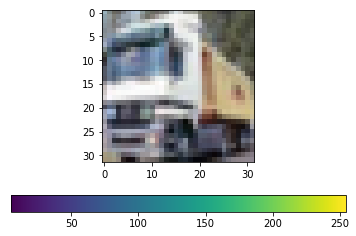

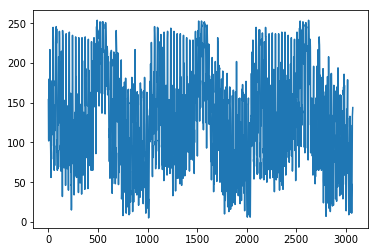

In [77]:
#showing 1 observation with element values, not very intuitive
im = plt.imshow(sample_image)
plt.colorbar(im, orientation='horizontal')
plt.show()
plt.plot(X[1,])
plt.show()


Stats of batch #1:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 1005
Label Counts of [1](AUTOMOBILE) : 974
Label Counts of [2](BIRD) : 1032
Label Counts of [3](CAT) : 1016
Label Counts of [4](DEER) : 999
Label Counts of [5](DOG) : 937
Label Counts of [6](FROG) : 1030
Label Counts of [7](HORSE) : 1001
Label Counts of [8](SHIP) : 1025
Label Counts of [9](TRUCK) : 981

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


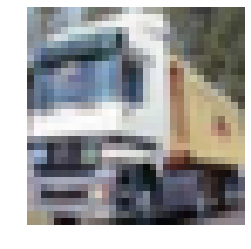

In [78]:
batch_id = 1
sample_id = 1
sample_image=display_stats( "data/", batch_id, sample_id)

To further verify data quality we randomly sampled a few pictures to check that they were in fact labeled correctly. All the ones we checked were correct. Since this is a widely used data set that has been used for over ten years (initially published April 8, 2009) we believe that the pictures are in fact labeled correctly and any initial problems have been corrected. Regardless, we keep a watchful eye for any inaccuracies.

# Modeling and Evaluation
Using machine learning to detect,process and classify images is becoming a very common occurrence. It is being used in a variety of fields on a variety of projects. Some examples are for the detection of oil spills in satellite radar images as well as gender classification on real-world face images. 

The first step in image processing is to segment the images. A common segmenting step is to segment the interest area from the background. A good initial segment will lead to easier analysis in the following image processing steps.

We can achieve this segmenting by clustering. Clustering is commomnly used because they are simple and fast algorithms. 

For our project we used the following clustering techniques:

 * K-Means
 * Agglomerative 
 * DBSCAN 
 

We warm up with an analysis of the image below and the effect of different clustering techniques. For consistency we will use 6 clusters for all three models.

<class 'numpy.ndarray'>
(32, 32, 3)


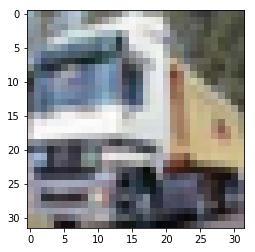

In [79]:
print(type(sample_image))
print(sample_image.shape)
#a 3 dimensional array
plt.imshow(sample_image)

## <font color='blue'> K-Means <font>
Our easiest clustering method is K-Means and we start with an arbitrary number of clusters for our sample image above. The model groups the points so that the sum of squares from points to the assigned cluster are minimal. Measure of distance for our points to the centroid uses Euclidean distance. The clustering for our data is based on values assigned to each pixel ranging from 0-255. Pixel values in our plane below are grouped around these common element values.

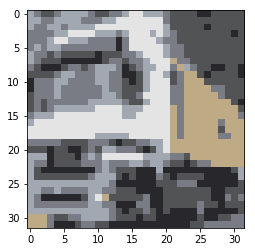

In [80]:
#convert it into 2d array, lenght of 32x32 and width of 3(RGB)
x,y,z=sample_image.shape
image2d = sample_image.reshape(x*y,z)
image2d.shape
#K-Means Clusteringimage2d
# K-Means Clustering

kmeans_cluster = cluster.KMeans(n_clusters=6,init='k-means++',random_state=1)
kmeans_cluster.fit(image2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_
plt.figure()

plt.imshow((cluster_centers[cluster_labels].reshape(x, y, z))/255)

## <font color="green">Agglomerative <font>
 Our agglomerative model differs as it labels all our pixels as individual clusters and progressively merges them. Our dendogram suggest an optimal clustering of 5, if we were to run a straight line across 75 we can see the 5 suggested clusters. The clusters below do not show clusters overlapped in the photo above but are a graph of element ranges from 0-255 and shows us the clustering by element types.

Different parameter we can control is how the distance between clusters is calculated

* single - shortest point is between two points from each cluster
* complete - longest distance between two points
* average -  distance between every point
* ward - distance between clusers is sum of squared differences within all clusters

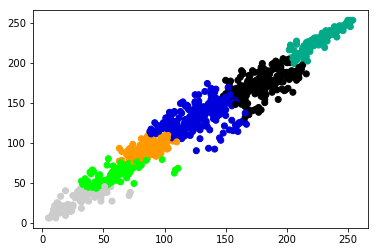

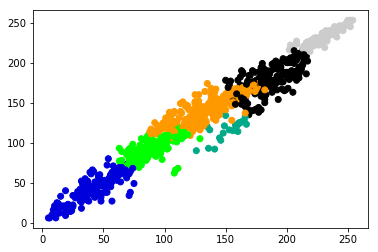

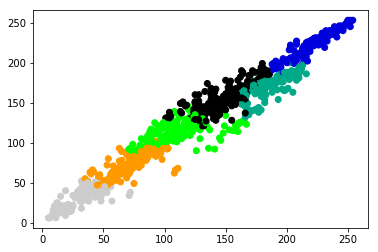

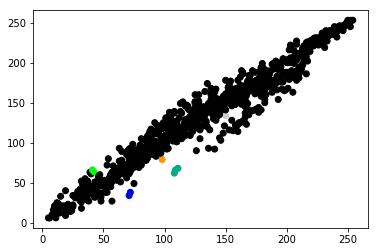

[0 0 0 ... 0 0 0]


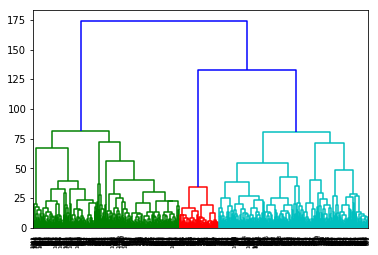

In [118]:

for linkage in ('ward', 'average', 'complete', 'single'):
    cls_fam = AgglomerativeClustering(n_clusters=6, linkage=linkage)
    cls_fam.fit(image2d)
    newfeature_fam = cls_fam.labels_
    plt.scatter(image2d[:, 0], image2d[:, 1], c=newfeature_fam,cmap=plt.cm.nipy_spectral)
#   plt.imshow((image2d[:, 0], image2d[:, 1], ))
    plt.show()

print(newfeature_fam)

#plt.imshow((cluster_centers[newfeature_fam].reshape(x, y, z))/255)

dendrogram = sch.dendrogram(sch.linkage(image2d, method='average'))

## <font color="purple"> DBSCAN <font>

Focusing on density of our elements by similar values we can use DBSCAN. Our two parameters we can control are the suspected radius of our cluster and number of points within each cluster.


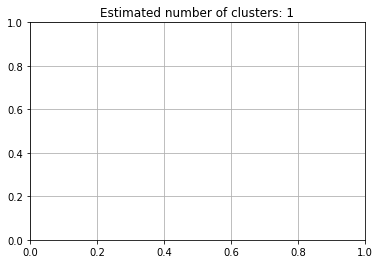

In [129]:

db = DBSCAN(eps=500, min_samples=500).fit(image2d)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# mark the samples that are considered "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

plt.figure()
unique_labels = set(labels) # the unique labels
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        # plot the core points in this class
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.grid()
    plt.show()

## Parameters

We can get help in selecting the optimal cluster number by looking at diminishing returns as we increase our clusters the amount our SSE reduces is reduced. We use a tool called an elbow plot. We also use a separate tool for helping us assess the optimal distance. Parameters below will look through a dataset containing several thousand observations instead of the previous single image.

* ####  Plots

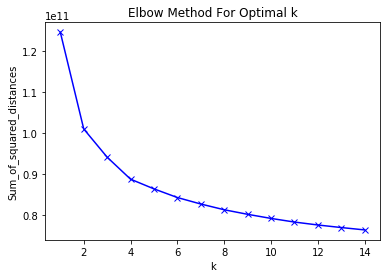

In [131]:
#elbow plot
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#optimal clusters seems to gravitate towards 4-8

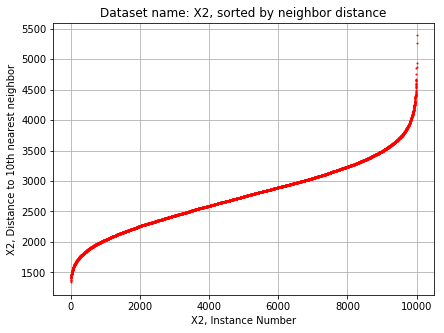

In [130]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X2_N = 10
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X2_knn_graph = kneighbors_graph(X, X2_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
plt.grid()

plt.show()

### Model effectiveness

Even though all our models work well in theory, we measure the effectiveness to see which is the optimal model. We perform cross validation and determine the accuracy.

In [134]:
cv = StratifiedKFold(n_splits=4)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

In [136]:
#KMEANS
params = []

cls_fam = KMeans(n_clusters=6, init='k-means++',random_state=1)
cls_fam.fit(X)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

acc = cross_val_score(clf,X,Y,cv=cv)
params.append((clf,acc.mean()*100,acc.std()*100)) # save state

print ("Clusters Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters Average accuracy =  41.64937209298517 +- 0.748301605239063


In [ ]:
#Agglomerative Clustering

params = []
for link in ['ward', 'complete', 'average']:

        cls_fam = AgglomerativeClustering(n_clusters=6, linkage=link)
        cls_fam.fit(X)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        acc = cross_val_score(clf,X,Y,cv=cv)
        params.append((clf,acc.mean()*100,acc.std()*100)) # save state

        print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  41.64937209298517 +- 0.748301605239063
Average accuracy =  41.64937209298517 +- 0.748301605239063


In [ ]:
#DBSCAN clustering

params = []

cls_fam = DBSCAN(eps=2000, min_samples=1000)
cls_fam.fit(X)
newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering


acc = cross_val_score(clf,X,Y,cv=cv)
params.append((clf,acc.mean()*100,acc.std()*100)) # save state

print (eps,min_samples,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

We find that the model with the best accuracy is the  <font color='red'> FILL IN HERE.<font>

# Deployment
#### Interested Parties

Our model is useful for an automobile company that is interested in entering the autonomous driver field. Our model can assist in the recognition of obstacles a person may encounter on the road and this can impact the breaking speed as well as other response measures in a vehicle. Additional data that could be collected could be images of frequently encountered animals that are encountered on roadways.

Another company that may find our model useful would be a company that focuses on products for the visibly impaired.  With our model a device can be made or improved that can notify a visibly impaired person the difference between a snake and a stick in their path.

If we were able to train on images of internal organs then we can translate our model into the medical field. The medical field uses image processing for interpretation of X-ray images, blood/cellular microscope images and a multitude of other instances. Our algorithm could improve the  current image processing by reducing the "noise" in the images as well as pointing out items that wouls other wise be considered "noise" and would go undetected.

#### Additional Data
Other data that should be collected are images of multiple subjects in a single image. All our images are of a single subject in a single image. It would be beneficial to have data with multiple subjects to train the model to look for various subjects at once.

There is another dataset that is currently available; CIFAR-100. This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs). This dataset would be very beneficial to look at but it is much larger scope and would require more computing resources.





<font color='red'> Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? 
If not, can you reign in the utility of your modeling? 
How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? 
• How would your deploy your model for interested parties? 
• What other data should be collected? 
• How often would the model need to be updated, etc.?<font>

## Clustering with t-sne

T-Distribution Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. 

T-sne is a non-linear dimensionality reduction technique which preserves the clustering of similar points in higher dimensions by mapping the high dimensional points to a probability density function, PDF, and then comparing that to a low dimensional PDF.  The algorithm seeks to minimize the divergence of these two PDFs.  The classical method for measuring the difference between two probabilities distributions is the Kullback–Leibler divergence algoritm. t-sne applies the KL Divergence as a loss function, and then uses stochasitc gradient descent to optimize the function.

Traditional dimensionality reduction techniques such as Principal Components Analysis, PCA, are linear techniques that maximize the distance of low-dimensional representations of high variance datapoints far apart. For high-dimensional data that can be projected onto a low-dimensional, non-linear plane, it is important for classification and for visualization to keep the similar datapoints clustered together.  This goal is typically not possible with a linear technique.

While t-sne is built into sklearn, the implementation therein is too slow to be used on Cifar10.  However, [parameteric techniques](https://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf) have been shown to be a little bit faster, and aproximation techniques such as[t-SNE-CUDA](https://arxiv.org/pdf/1807.11824v1.pdf), the fastest yet, have proven scalable to larger datasets.  

We've implemented parametric t-SNE in Keras based upon the original code written for Python 2 [here](https://github.com/zaburo-ch/Parametric-t-SNE-in-Keras) to try and get t-sne to plot the clustering of color distributions in our dataset. 

In [45]:
import numpy as np
np.random.seed(71)

from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.datasets import cifar10

import multiprocessing as mp
import math

In [46]:
def Hbeta(D, beta):
  P = np.exp(-D * beta)
  sumP = np.sum(P) + 10e-15
  
  H = np.log(sumP) + beta * np.sum(D * P) / sumP
  P = P / sumP
  return H, P

In [47]:
def x2p_job(data):
    i, Di, tol, logU = data
    beta = 1.0
    betamin = -np.inf
    betamax = np.inf
    H, thisP = Hbeta(Di, beta)

    Hdiff = H - logU
    tries = 0
    while np.abs(Hdiff) > tol and tries < 50:
        if Hdiff > 0:
            betamin = beta
            if betamax == -np.inf:
                beta = beta * 2
            else:
                beta = (betamin + betamax) / 2
        else:
            betamax = beta
            if betamin == -np.inf:
                beta = beta / 2
            else:
                beta = (betamin + betamax) / 2

        H, thisP = Hbeta(Di, beta)
        Hdiff = H - logU
        tries += 1

    return i, thisP

In [48]:
def x2p(X):
    tol = 1e-5
    n = X.shape[0]
    logU = np.log(perplexity)

    sum_X = np.sum(np.square(X), axis=1)
    D = sum_X + (sum_X.reshape([-1, 1]) - 2 * np.dot(X, X.T))

    idx = (1 - np.eye(n)).astype(bool)
    D = D[idx].reshape([n, -1])

    def generator():
        for i in range(n):
            yield i, D[i], tol, logU

    pool = mp.Pool(n_jobs)
    result = pool.map(x2p_job, generator())
    P = np.zeros([n, n])
    for i, thisP in result:
        P[i, idx[i]] = thisP

    return P

In [49]:
def calculate_P(X):
    n = X.shape[0]
    P = np.zeros([n, batch_size])
    for i in range(0, n, batch_size):
        P_batch = x2p(X[i:i + batch_size])
        P_batch[np.isnan(P_batch)] = 0
        P_batch = P_batch + P_batch.T
        P_batch = P_batch / P_batch.sum()
        P_batch = np.maximum(P_batch, 1e-12)
        P[i:i + batch_size] = P_batch
    return P

In [50]:
def KLdivergence(P, Y):
    low_dim = 2
    alpha = low_dim - 1.
    sum_Y = K.sum(K.square(Y), axis=1)
    eps = K.variable(10e-15)
    D = sum_Y + K.reshape(sum_Y, [-1, 1]) - 2 * K.dot(Y, K.transpose(Y))
    Q = K.pow(1 + D / alpha, -(alpha + 1) / 2)
    Q *= K.variable(1 - np.eye(batch_size))
    Q /= K.sum(Q)
    Q = K.maximum(Q, eps)
    C = K.log(P) - K.log(Q)
    C = K.sum(P * C)
    return C

In [51]:
def LoadData():
  print ("Loading cifar-10")
  (X_train, y_train), (X_test, y_test) = cifar10.load_data()

  dataset = (X_train, y_train), (X_test, y_test)
  return dataset

In [52]:
def Reshape(dataset):
  (X_train, y_train), (X_test, y_test) = dataset
  n, channel, row, col = X_train.shape
  X_train = X_train.reshape(-1, channel * row * col)
  X_test = X_test.reshape(-1, channel * row * col)
  
  print ("X_train.shape:", X_train.shape)
  print ("X_test.shape:", X_test.shape)

  dataset = (X_train, y_train), (X_test, y_test), n
  return dataset

In [53]:
def Normalize(dataset):
  (X_train, y_train), (X_test, y_test), n = dataset
  print ("Max in training data before scaling:", str(np.max(X_train)))
  
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_train /= 255
  X_test /= 255
  minimum = np.min(X_train)
  maximum = np.max(y_train)
  
  print ("Max in training data after scaling:", str(np.max(X_train)))
  
  dataset = (X_train, y_train), (X_test, y_test), n
  return dataset

In [41]:
def GenerateBatch(batch_size,nb_epoch):
  for epoch in range(nb_epoch):
    for i in range(0, n, batch_size):
      yield(X_train[i:i+batch_size], calculate_P(X_train[i:i+batch_size]))


In [42]:
# reload data
(X_train, y_train), (X_test, y_test), n  = Normalize(Reshape(LoadData()))
n = 10000
X_train = X_train[0:n]
y_train = y_train[0:n]

Loading cifar-10
X_train.shape: (50000, 3072)
X_test.shape: (10000, 3072)
Max in training data before scaling: 255
Max in training data after scaling: 1.0


In [43]:
perplexity = 30.0
n_jobs = 5
nb_epoch = 2
batch_size = 100


# build model
model = Sequential()
model.add(Dense(20, input_shape=(X_train.shape[1],),activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(2))
model.compile(loss=KLdivergence, optimizer="adam")


# fit model
history = model.fit_generator(GenerateBatch(batch_size,nb_epoch),steps_per_epoch=math.ceil(n/batch_size),epochs=nb_epoch, shuffle = True)


W0811 21:41:06.322164 4555089344 deprecation_wrapper.py:119] From /anaconda3/envs/lab4/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 21:41:06.356776 4555089344 deprecation_wrapper.py:119] From /anaconda3/envs/lab4/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 21:41:06.361802 4555089344 deprecation_wrapper.py:119] From /anaconda3/envs/lab4/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 21:41:06.397563 4555089344 deprecation_wrapper.py:119] From /anaconda3/envs/lab4/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0811 21:41:06.427365 4555089344 dep

Epoch 1/2
100/100 [==============================] - 12s 116ms/step - loss: 0.5052
Epoch 2/2
100/100 [==============================] - 33s 333ms/step - loss: 0.4787


In [59]:
# plot 
fig = plt.figure(figsize=(5, 5))
pred = model.predict(X_test)
plt.scatter(pred[:, 0], pred[:, 1],c=pred[:, 0],cmap="Spectral",marker='o', s=4, edgecolor='')
fig.tight_layout()
plt.show()

/anaconda3/envs/lab4/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  
